# Hurricanes detection and tracking
By Yanis Grit and Dylan Rachwal


## Introduction

**Before starting:**

You need to install Basemap. Do it only once.

In [ ]:
!pip install basemap

     |████████████████████████████████| 858 kB 32.7 MB/s 
     |████████████████████████████████| 219 kB 69.7 MB/s 
     |████████████████████████████████| 30.5 MB 39.7 MB/s 
     |████████████████████████████████| 6.3 MB 64.4 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=64c096177f0e81ae263bdb40a97faf1fa241389dc7891b18ba4f69394662603c
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


**Goal of this Notebook:**

In this notebook, we will try to focus on the detection and tracking of different hurricanes that happenned in the Gulf of Mexico between 1998 to 2015.
We will use the whole database given by the course and retrieve important informations from the NOAA ressources we can find here : [NOAA Website](https://coast.noaa.gov/hurricanes/#map=4.91/45.27/-94.11&search=eyJzZWFyY2hTdHJpbmciOiJDdXN0b20gUG9seWdvbiIsInNlYXJjaFR5cGUiOiJwb2x5Z29uIiwibWF0Y2giOiJwYXJ0aWFsIiwiZ2VvanNvbiI6eyJjb29yZGluYXRlcyI6W1tbLTg1LjAwNTUwNDg3MzczNjQzLDI3Ljk0MDI4NDM2NjEwNTA3NV0sWy05MC45ODE5MDIzNjk5NDIxLDI3Ljk3ODUzNjc3MTU1MzYzNV0sWy05MC45NTMwMzA4ODQ0NTI5NCwyMy45ODI4NDkxMzcwMzk2OF0sWy04NC45OTEwNjkxMzA5OTE4NywyMy45ODI4NDkxMzcwMzk2OF0sWy04NS4wMDU1MDQ4NzM3MzY0MywyNy45NDAyODQzNjYxMDUwNzVdXV0sInR5cGUiOiJQb2x5Z29uIn0sImNhdGVnb3JpZXMiOlsiSDUiLCJINCIsIkgzIiwiSDIiLCJIMSIsIlRTIl0sInllYXJzIjpbIjIwMTUiLCIyMDE0IiwiMjAxMyIsIjIwMTIiLCIyMDExIiwiMjAxMCIsIjIwMDkiLCIyMDA4IiwiMjAwNyIsIjIwMDYiLCIyMDA1IiwiMjAwNCIsIjIwMDMiLCIyMDAyIiwiMjAwMSIsIjIwMDAiLCIxOTk5IiwiMTk5OCJdLCJtb250aHMiOltdLCJlbnNvIjpbXSwicHJlc3N1cmUiOnsicmFuZ2UiOlswLDExNTBdLCJpbmNsdWRlVW5rbm93blByZXNzdXJlIjp0cnVlfSwic2VsZWN0ZWRTdG9ybUlEIjoiMjAxMjIzNE4xNjMxNSIsImJ1ZmZlclVuaXQiOlsiTWlsZXMiXSwic29ydFNlbGVjdGlvbiI6eyJ2YWx1ZSI6InllYXJzX25ld2VzdCIsImxhYmVsIjoiWWVhciAoTmV3ZXN0KSJ9LCJhcHBseVRvQU9JIjp0cnVlLCJpc1N0b3JtTGFiZWxzVmlzaWJsZSI6dHJ1ZX0=) .

The work will be first the detection of the hurricane using the Sea Surface Temperature (SST) for  the Gulf of Mexico zone between longitudes (270, 274) and latitudes (24,28). Then we will see the trails of cooler water that happend during Katrina (august 2005) and Rita (September 2005)

### **Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)
- numpy (data structures and manipulation tools)
- datetime (time manipulation tools)


In [ ]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import datetime
import sklearn
from sklearn.svm import SVR
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
from ipywidgets import interactive
import imageio
import os
import numpy as np
from google.colab import files
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size

Populating the interactive namespace from numpy and matplotlib


### **Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [ ]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name, **kwargs):

    # plot
    plot_date(time,ts,line_type, **kwargs)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

### **Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. using the following command.

In [ ]:
from google.colab import auth
auth.authenticate_user()

### **NOAA Listed Hurricanes:**

In [ ]:
known_hurricanes = pd.DataFrame(np.array([["Earl", datetime.datetime(1998, 8, 31).toordinal(), datetime.datetime(1998, 9, 8).toordinal()],
                                          ["Georges", datetime.datetime(1998, 9, 15).toordinal(), datetime.datetime(1998, 10, 1).toordinal()],
                                          ["Mitch", datetime.datetime(1998, 10, 22).toordinal(), datetime.datetime(1998, 11, 9).toordinal()],
                                          ["Harvey", datetime.datetime(1999, 9, 19).toordinal(), datetime.datetime(1999, 9, 22).toordinal()],
                                          ["Gordon", datetime.datetime(2000, 9, 14).toordinal(), datetime.datetime(2000, 9, 21).toordinal()],
                                          ["Helene", datetime.datetime(2000, 9, 15).toordinal(), datetime.datetime(2000, 9, 25).toordinal()],
                                          ["Barry_2001", datetime.datetime(2001, 8, 2).toordinal(), datetime.datetime(2001, 8, 8).toordinal()],
                                          ["Hanna", datetime.datetime(2002, 9, 12).toordinal(), datetime.datetime(2002, 9, 15).toordinal()],
                                          ["Isidore", datetime.datetime(2002, 9, 14).toordinal(), datetime.datetime(2002, 9, 27).toordinal()],
                                          ["Lili", datetime.datetime(2002, 9, 21).toordinal(), datetime.datetime(2002, 10, 4).toordinal()],
                                          ["Bill", datetime.datetime(2003, 6, 28).toordinal(), datetime.datetime(2003, 7, 3).toordinal()],
                                          ["Claudette", datetime.datetime(2003, 7, 7).toordinal(), datetime.datetime(2003, 7, 17).toordinal()],
                                          ["Erika", datetime.datetime(2003, 8, 14).toordinal(), datetime.datetime(2003, 8, 17).toordinal()],
                                          ["Henri", datetime.datetime(2003, 9, 3).toordinal(), datetime.datetime(2003, 9, 8).toordinal()],
                                          ["Bonnie_2004", datetime.datetime(2004, 8, 3).toordinal(), datetime.datetime(2004, 8, 14).toordinal()],
                                          ["Ivan", datetime.datetime(2004, 9, 2).toordinal(), datetime.datetime(2004, 9, 24).toordinal()],
                                          ["Arlene", datetime.datetime(2005, 6, 8).toordinal(), datetime.datetime(2005, 6, 14).toordinal()],
                                          ["Cindy", datetime.datetime(2005, 7, 3).toordinal(), datetime.datetime(2005, 7, 11).toordinal()],
                                          ["Dennis", datetime.datetime(2005, 7, 4).toordinal(), datetime.datetime(2005, 7, 18).toordinal()],
                                          ["Katrina", datetime.datetime(2005, 8, 23).toordinal(), datetime.datetime(2005, 8, 31).toordinal()],
                                          ["Rita", datetime.datetime(2005, 9, 18).toordinal(), datetime.datetime(2005, 9, 26).toordinal()],
                                          ["Alberto", datetime.datetime(2006, 6, 10).toordinal(), datetime.datetime(2006, 6, 19).toordinal()],
                                          ["Barry_2007", datetime.datetime(2007, 5, 31).toordinal(), datetime.datetime(2007, 6, 5).toordinal()],
                                          ["Olga", datetime.datetime(2007, 12, 10).toordinal(), datetime.datetime(2007, 12, 16).toordinal()],
                                          ["Gustav", datetime.datetime(2008, 8, 25).toordinal(), datetime.datetime(2008, 9, 5).toordinal()],
                                          ["Ike", datetime.datetime(2008, 9, 1).toordinal(), datetime.datetime(2008, 9, 15).toordinal()],
                                          ["Ida", datetime.datetime(2009, 11, 4).toordinal(), datetime.datetime(2009, 11, 11).toordinal()],
                                          ["Bonnie_2010", datetime.datetime(2010, 7, 22).toordinal(), datetime.datetime(2010, 7, 25).toordinal()],
                                          ["Five", datetime.datetime(2010, 8, 10).toordinal(), datetime.datetime(2010, 8, 18).toordinal()],
                                          ["Don", datetime.datetime(2011, 7, 27).toordinal(), datetime.datetime(2011, 7, 30).toordinal()],
                                          ["Debby", datetime.datetime(2012, 6, 23).toordinal(), datetime.datetime(2012, 6, 27).toordinal()],
                                          ["Isaac", datetime.datetime(2012, 8, 20).toordinal(), datetime.datetime(2012, 9, 1).toordinal()],
                                          ["Andrea", datetime.datetime(2013, 6, 5).toordinal(), datetime.datetime(2013, 6, 8).toordinal()],
                                          ["Karen", datetime.datetime(2013, 10, 3).toordinal(), datetime.datetime(2013, 10, 6).toordinal()]]), columns = ['name', 'start', 'end'])
date_known_hurricanes= array([])
for index,row in known_hurricanes.iterrows():
  date_known_hurricanes = concatenate((date_known_hurricanes, np.arange(int(row['start']), int(row['end'])+1, 1)))

## Part 1) Quick overview of the data and the event specification

In [ ]:
%%bigquery --project alert-ground-261008 output
SELECT time, AVG(sst) as daily_mean_sst, STDDEV(sst) as std_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>270 AND lon<274 AND lat>24 AND lat<28
GROUP BY time
ORDER BY time

In [ ]:
temperature_variation = output.daily_mean_sst.diff()
temperature_variation

0            NaN
1      -0.246094
2      -0.343359
3      -0.029883
4       0.264844
          ...   
6569   -0.181055
6570   -0.171094
6571    0.099609
6572    0.285937
6573    0.106641
Name: daily_mean_sst, Length: 6574, dtype: float64

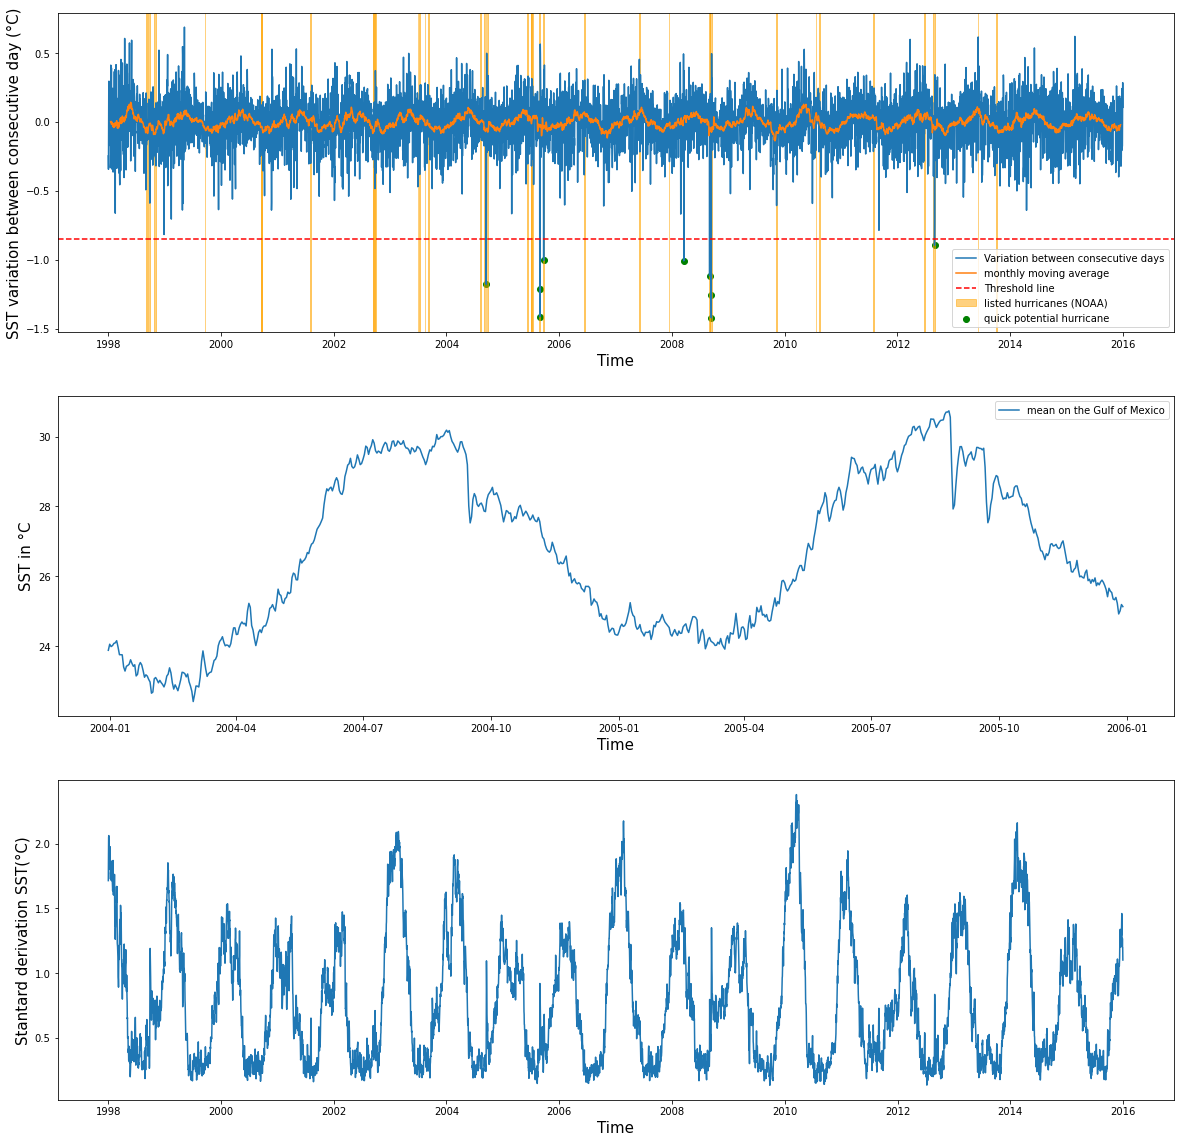

In [ ]:
plt.subplot(311)
plot_ts(output.time,temperature_variation,'-','SST variation between consecutive day (°C)', label = 'Variation between consecutive days')
monthly_moving_average=np.convolve(temperature_variation, np.ones(31), 'valid') / 31
monthly_date=np.convolve(output.time, np.ones(31), 'valid') / 31
for index,hurricane in known_hurricanes.iterrows():
  line = plt.axvspan(datetime.datetime.fromordinal(int(hurricane['start'])), datetime.datetime.fromordinal(int(hurricane['end'])) , alpha=0.5, color='orange')
line.set_label("listed hurricanes (NOAA)")
plot_ts(monthly_date, monthly_moving_average,'-','SST variation between consecutive day (°C)', label = 'monthly moving average')
plt.axhline(y=-.85, color='r', linestyle='--', label = 'Threshold line')
threshold = temperature_variation <-.85
plt.scatter(output.time[threshold], temperature_variation[threshold], marker='o', color='g', edgecolors='g', label = 'quick potential hurricane')
plt.legend()
plt.subplot(312)
plot_ts(output.time[6*365: 8*365],output.daily_mean_sst[6*365: 8*365],'-','SST in °C', label='mean on the Gulf of Mexico')
plt.legend()
plt.subplot(313)
plot_ts(output.time,output.std_sst,'-','Stantard derivation SST(°C)')

plt.show()

We observe that mostly there is a huge loss of temperature of the sea surface which is due to the fact that hurricane needs heat to get energy and to grow. However we can observe some kind of seasonal cycle that can reduce the precision of our algorithms. Let's now focus more precisely on the standard deviation and derivative of the data.

## Part 2) Detection of hurricanes

### The Derivative of the SST
Let's see what happens for the derivative of the SST. An Hurricane needs a lot of energy, therefore we expect to see a lot of point at the bottom right of the phase diagram because there are high temperature and huge negative variation

In [ ]:
### Tentative portrait de phase SSTt / SST ### toutes les données, nouvelle fenêtre 

%%bigquery --project alert-ground-261008 phase
SELECT time, month, lon, lat, avg(sst) as avg_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>269 AND lon<275 AND lat>24 AND lat<28 
GROUP BY lon, lat, time, month
ORDER BY time

In [ ]:
lats = arange(24.125,28.125,0.25)
lons = arange(269.125,275.125,0.25)

#data = []
differences = array([]).reshape((-1,1))
data = zeros(6).reshape((1,-1))
figure()
for i in lons:
  for j in lats:
    extract = phase.where((phase.lon==i) & (phase.lat==j)).dropna()
    #print(extract.shape)
    sst_diff_extract = extract.avg_sst.diff().to_numpy().reshape((-1,1))
    #print(sst_diff_extract.shape)
    #print(extract.shape)
    extract=concatenate((extract.to_numpy(), sst_diff_extract),axis=1)
    #print(extract.shape) # colonnes : time, lon, lat, avg_sst, sst_diff
    #scatter(extract[:,4], extract[:,5])
    data = concatenate((data, extract))
show()

print(data.shape)
print(lats.shape[0]*lons.shape[0]*365)


<Figure size 1440x1440 with 0 Axes>

(2524417, 6)
140160


Text(0, 0.5, 'SST4 in C°/day')

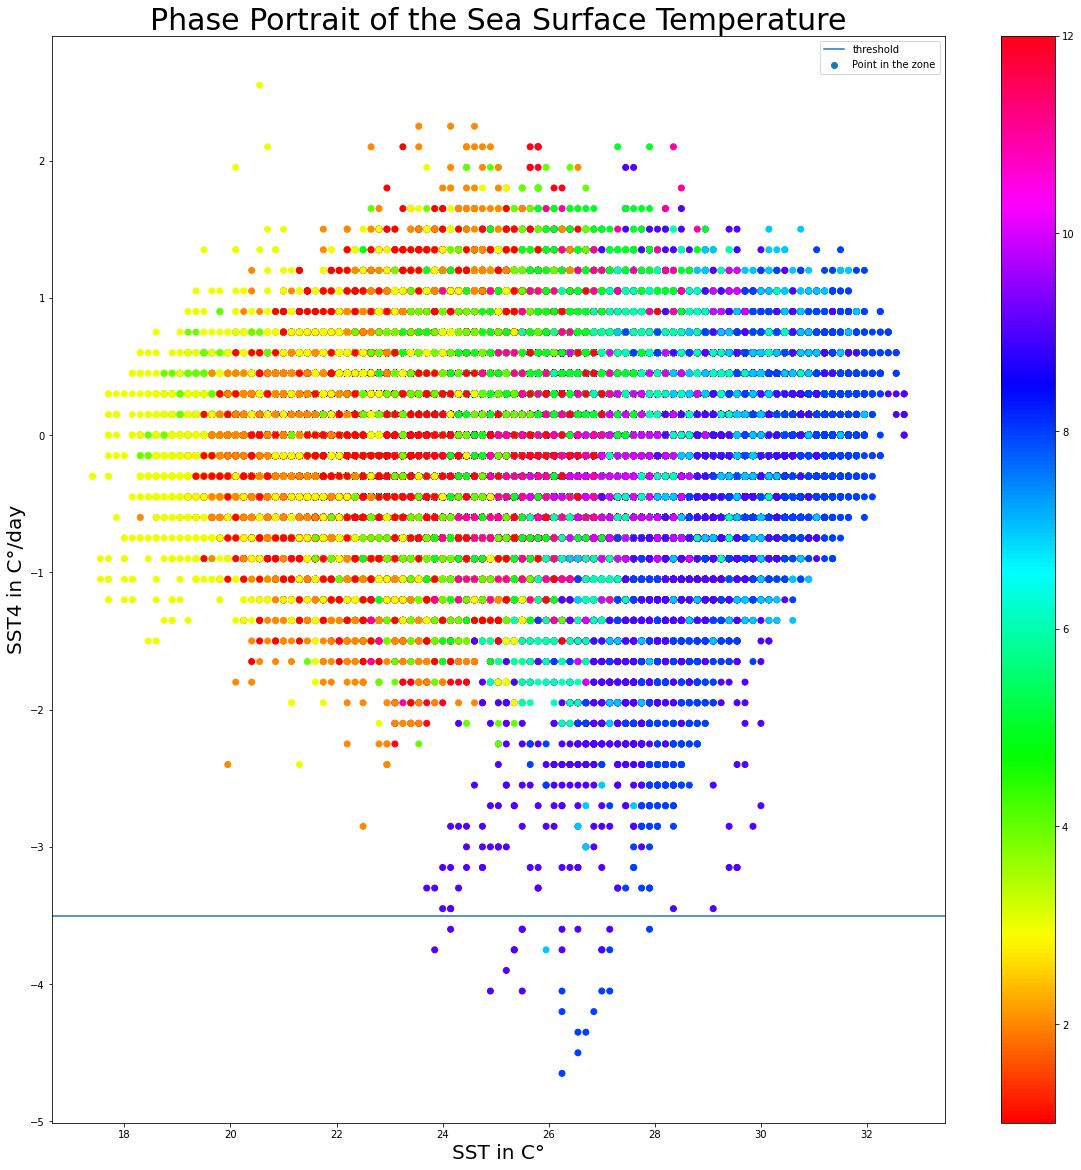

In [ ]:
scatter(data[1:,4], data[1:,5], c=data[1:,1], cmap='hsv', label = 'Point in the zone')
colorbar()
axhline(y=-3.5, label='threshold')
legend()
title('Phase Portrait of the Sea Surface Temperature', size=30)
xlabel('SST in C°', size='20')
ylabel('SST4 in C°/day', size='20')


Indeed we are definetely having our cluster that would probably be a cluster of different hurricanes. Now we are gonna fine tunning the results by grouping by location

In [ ]:
## Moyenne spatiale SST vs différences journalières
%%bigquery --project alert-ground-261008 phase2
SELECT time, month, avg(sst) as avg_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>269 AND lon<275 AND lat>24 AND lat<28 
GROUP BY time, month
ORDER BY time

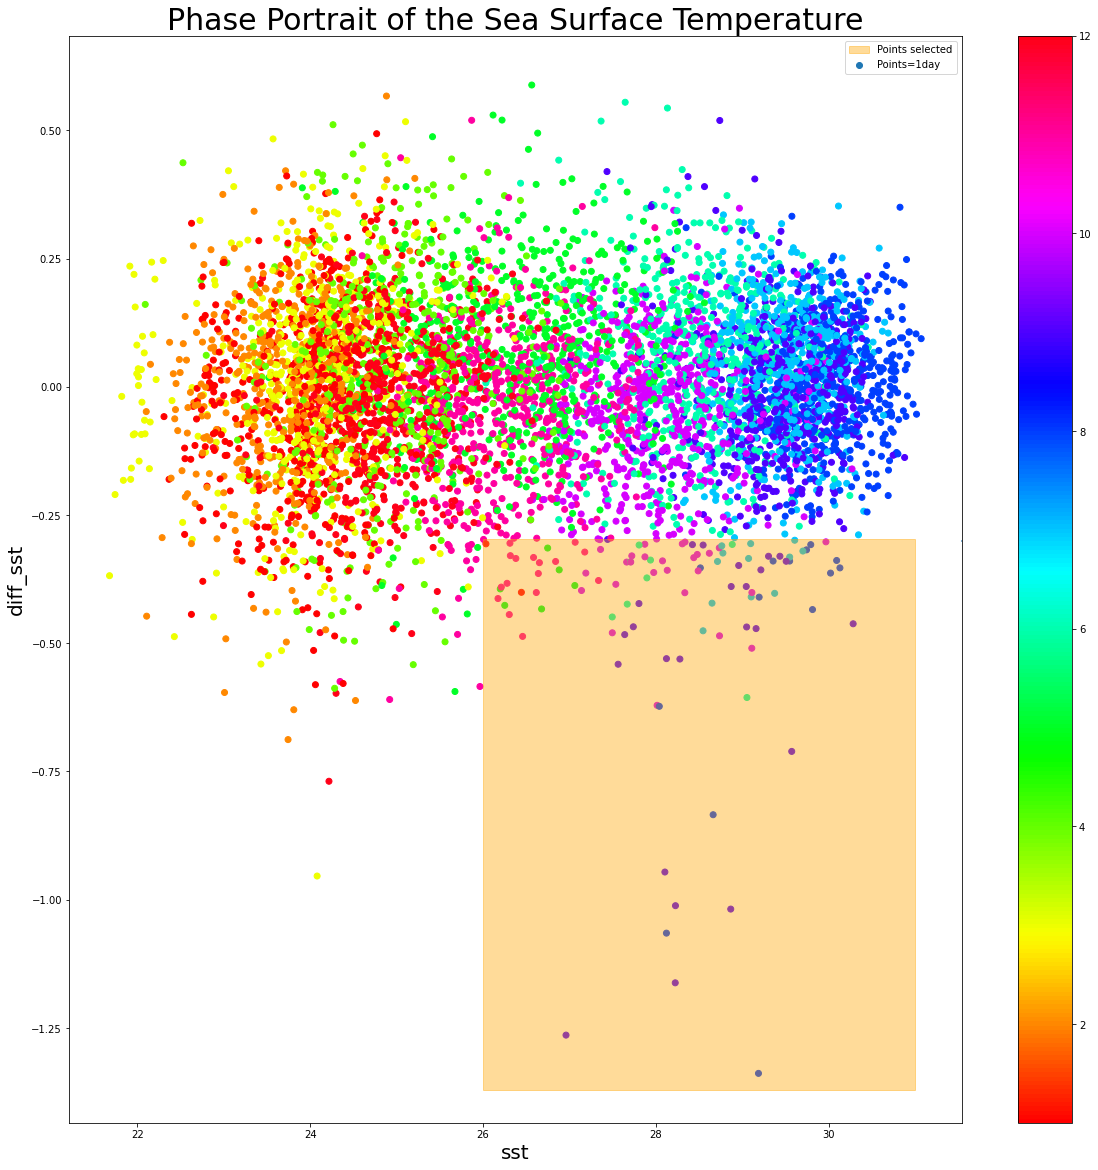

In [ ]:
diff = phase2.avg_sst.diff()
plt.scatter(phase2.avg_sst, diff, c=phase2.month, cmap = 'hsv', label = 'Points=1day')
plt.axvspan(xmin=26,xmax=31,ymin=0.03,ymax=0.5366, alpha = 0.4, color = 'orange', label='Points selected')
xlabel("sst",size=20)
ylabel('diff_sst',size=20)
plt.legend()
title('Phase Portrait of the Sea Surface Temperature', size=30)
colorbar()
axhline(y=-.3, xmin=26)
plt.show()

Now let's see with an adapted threshold if those points are definetely listed hurricanes

In [ ]:
extract = phase2.time[where((diff < -.35) & (phase2.avg_sst > 26)) [0]]


date_pot_hurricanes = []
false_hurricanes = []
cpt=0
for e in extract :
  if e in date_known_hurricanes:
    cpt +=1 
    if (e-1) not in date_pot_hurricanes and (e-2) not in date_pot_hurricanes :
      date_pot_hurricanes.append(e)
  else :
    false_hurricanes.append(datetime.datetime.fromordinal(int(e)))
      #print(e-1)

print('Number of Point detecting a listed hurricane :', cpt)
print('Precision :', cpt/len(extract))

pot_hurricanes = {}
for e in date_pot_hurricanes : 
  for index, row in known_hurricanes.iterrows():
    if int(row['start']) <= e and e <= int(row['end']):
      pot_hurricanes[row['name']]=datetime.datetime.fromordinal(int(e))
      break
pot_hurricanes

Number of Point detecting a listed hurricane : 22
Precision : 0.36065573770491804


{'Alberto': datetime.datetime(2006, 6, 12, 0, 0),
 'Barry_2001': datetime.datetime(2001, 8, 5, 0, 0),
 'Bill': datetime.datetime(2003, 6, 30, 0, 0),
 'Cindy': datetime.datetime(2005, 7, 10, 0, 0),
 'Earl': datetime.datetime(1998, 9, 2, 0, 0),
 'Erika': datetime.datetime(2003, 8, 15, 0, 0),
 'Georges': datetime.datetime(1998, 9, 27, 0, 0),
 'Gustav': datetime.datetime(2008, 9, 1, 0, 0),
 'Ike': datetime.datetime(2008, 9, 11, 0, 0),
 'Isaac': datetime.datetime(2012, 8, 28, 0, 0),
 'Isidore': datetime.datetime(2002, 9, 25, 0, 0),
 'Ivan': datetime.datetime(2004, 9, 15, 0, 0),
 'Katrina': datetime.datetime(2005, 8, 28, 0, 0),
 'Rita': datetime.datetime(2005, 9, 21, 0, 0)}

We can see that these points belong at 36% to hurricanes but they are not really different, some of them belong to the same hurricane. In fact, out of 31 listed hurricanes, we retrieve 14 of them.

[0, 0, 0, 1, 5, 3, 1, 2, 7, 11, 8, 1]


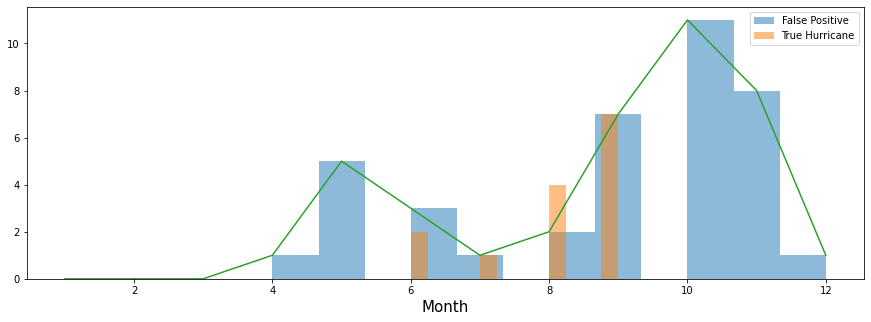

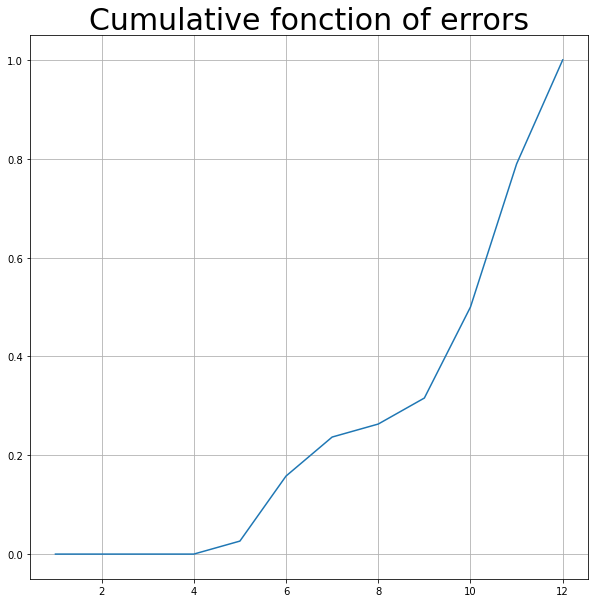

In [ ]:
figure(figsize=(15,5))
plt.hist([date.month for date in false_hurricanes], bins=12, alpha =0.5, label = 'False Positive')
plt.hist([value.month for key, value in pot_hurricanes.items()], bins=12, alpha =0.5, label = 'True Hurricane')
xlabel('Month', size=15)
mois=[]
legend()
for i in range(1, 13):
  mois.append(len(false_hurricanes)-count_nonzero([date.month-i for date in false_hurricanes]))

plot(arange(1,13),mois)
print(mois)
somme=[]
for k in range(12):
  somme.append(sum(mois[0:k]))
plt.show()
figure(figsize=(10,10))
title('Cumulative fonction of errors', size=30)
plot(arange(1,13),somme/somme[-1])
grid()

We can see that mostly our mistaken "hurricanes" doesn't belong to the cyconic period of the gulf of mexico. Therefore they might be related to strange cold oceanic water stream.

### The Standard deviation 
Let's try something else and use the Standard deviation and the RMSE of the SST

In [ ]:
%%bigquery --project alert-ground-261008 output
SELECT time, AVG(sst) as daily_mean_sst, STDDEV(sst) as std_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>270 AND lon<274 AND lat>24 AND lat<28
GROUP BY time
ORDER BY time

In [ ]:
%%bigquery --project alert-ground-261008 output5
SELECT dayofyear, avg(sst) as mean_sst, STDDEV(sst) as std_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>270 AND lon<274 AND lat>24 AND lat<28
GROUP BY dayofyear
ORDER BY dayofyear

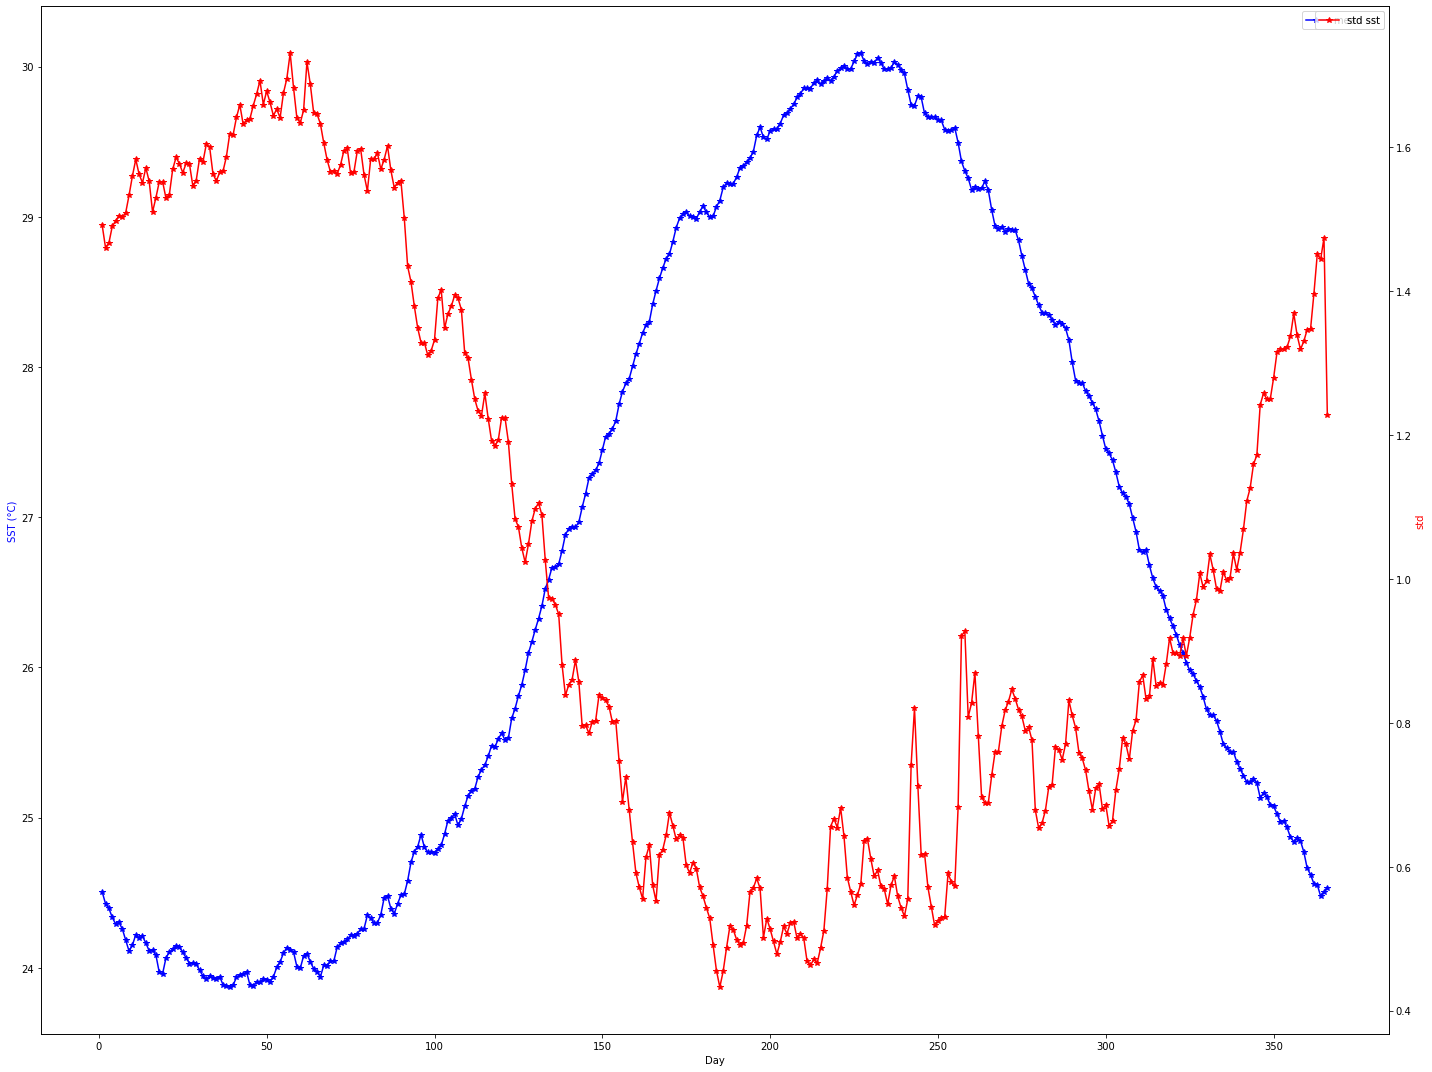

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,15))

ax1.plot(output5.dayofyear,output5.mean_sst,'-*', color = 'blue', label ='mean sst')
#ax1.plot(output5.dayofyear,q1_sst,'-', c='r', alpha =0.5)
#ax1.plot(output5.dayofyear,q3_sst,'-', c='r', alpha =0.5)
ax1.set_xlabel('Day')
ax1.set_ylabel('SST (°C)', color='b')
#ax1.fill_between(output5.dayofyear,q1_sst, q3_sst, alpha= 0.1, color='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(output5.dayofyear,output5.std_sst,'-*', color = 'red',label='std sst')
#ax2.plot(output5.dayofyear,q1_ssh,'-', c='c', alpha =0.5)
#ax2.fill_between(output5.dayofyear,q1_ssh, q3_ssh, alpha= 0.1, color='c')
#ax2.plot(output5.dayofyear,q3_ssh,'-', c='c', alpha =0.5)
ax2.set_xlabel('Day')
ax2.set_ylabel('std', color='r')

ax1.legend()
ax2.legend()
fig.tight_layout()  #

We observe that there is clean seasonal cycle over the 17 years. Therefore to have better precision we need to substract these cycles of the data.

In [ ]:
std_without_cycle=[]
mean_without_cycle=[]
for date in output.time.values:
  date_formated=datetime.datetime.fromordinal(int(date))
  days=(datetime.date(date_formated.year, date_formated.month, date_formated.day) - datetime.date(date_formated.year, 1, 1)).days + 1
  mean_without_cycle.append(output[output.time==date].daily_mean_sst.values - output5[output5.dayofyear == days].mean_sst.values )
  std_without_cycle.append(output[output.time==date].std_sst.values - output5[output5.dayofyear == days].std_sst.values )

<Figure size 360x1080 with 0 Axes>

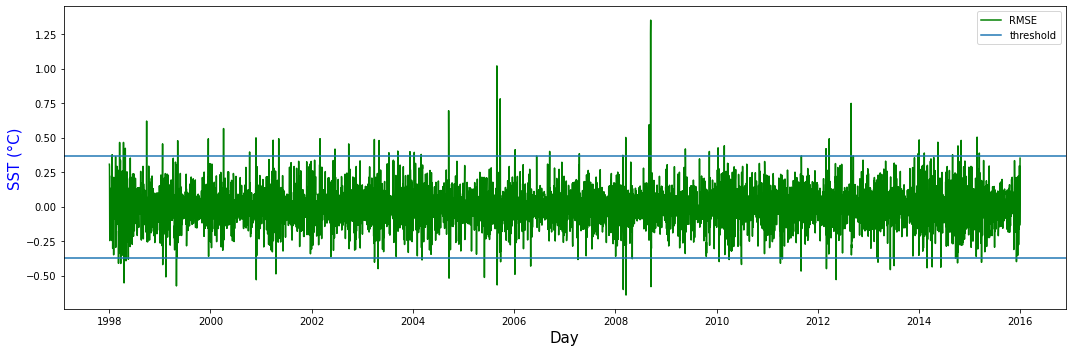

In [ ]:
start=0
end=-1
figure(figsize=(5, 15))
fig, ax1 = plt.subplots(figsize=(15, 5))
#plot_ts(output.time[start+1:end],np.diff(np.array(mean_without_cycle[start:end]),axis=0),'-','sst', label='mean', color='red')
#plot_ts(output.time[start+1:end],np.diff(np.array(std_without_cycle[start:end]),axis=0),'-','sst', label='std', color='blue')
plot_ts(output.time[start+1:end], np.diff((np.array(mean_without_cycle[start:end])**2+np.array(std_without_cycle[start:end])**2)**(1/2),axis=0), '-', 'sst', label='RMSE', c='green')
plt.axhline(y=.37, label= 'threshold')
plt.axhline(y=-.37)
#plot_ts(output.time[start:end],std_without_cycle[start:end],'-','sst', label='std', color='blue')
#plot_ts(output.time[start:end],mean_without_cycle[start:end],'-*','sst', label='mean', color='b', markersize=5, linewidth=1)
#ax1.plot(output5.dayofyear,q1_sst,'-', c='r', alpha =0.5)
#ax1.plot(output5.dayofyear,q3_sst,'-', c='r', alpha =0.5)
ax1.set_xlabel('Day')
ax1.set_ylabel('SST (°C)', color='b')
#ax1.fill_between(output5.dayofyear,q1_sst, q3_sst, alpha= 0.1, color='r')
#for index,hurricane in known_hurricanes.iterrows():
#  ax1.axvspan(int(hurricane['start']), int(hurricane['end']) , alpha=0.5, color='orange')

ax1.legend()
#ax2.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Nomber of points detecting a listed hurricane : 20
precision is  19.607843137254903
{'Georges': datetime.datetime(1998, 9, 27, 0, 0), 'Isidore': datetime.datetime(2002, 9, 24, 0, 0), 'Claudette': datetime.datetime(2003, 7, 11, 0, 0), 'Ivan': datetime.datetime(2004, 9, 17, 0, 0), 'Katrina': datetime.datetime(2005, 8, 31, 0, 0), 'Rita': datetime.datetime(2005, 9, 24, 0, 0), 'Gustav': datetime.datetime(2008, 8, 31, 0, 0), 'Ike': datetime.datetime(2008, 9, 13, 0, 0), 'Ida': datetime.datetime(2009, 11, 8, 0, 0), 'Isaac': datetime.datetime(2012, 8, 27, 0, 0), 'Andrea': datetime.datetime(2013, 6, 6, 0, 0)}


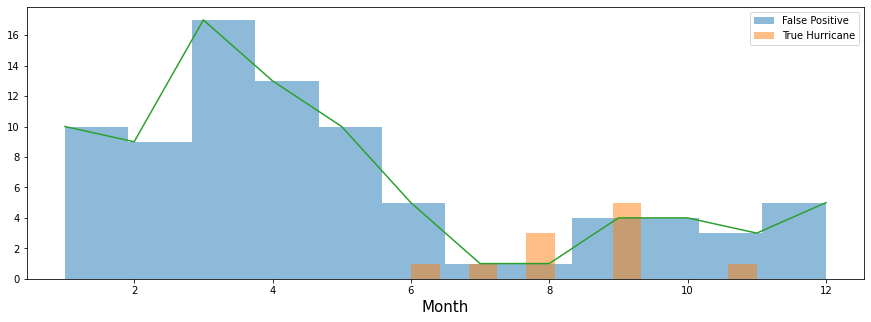

{'Andrea': datetime.datetime(2013, 6, 6, 0, 0),
 'Claudette': datetime.datetime(2003, 7, 11, 0, 0),
 'Georges': datetime.datetime(1998, 9, 27, 0, 0),
 'Gustav': datetime.datetime(2008, 8, 31, 0, 0),
 'Ida': datetime.datetime(2009, 11, 8, 0, 0),
 'Ike': datetime.datetime(2008, 9, 13, 0, 0),
 'Isaac': datetime.datetime(2012, 8, 27, 0, 0),
 'Isidore': datetime.datetime(2002, 9, 24, 0, 0),
 'Ivan': datetime.datetime(2004, 9, 17, 0, 0),
 'Katrina': datetime.datetime(2005, 8, 31, 0, 0),
 'Rita': datetime.datetime(2005, 9, 24, 0, 0)}

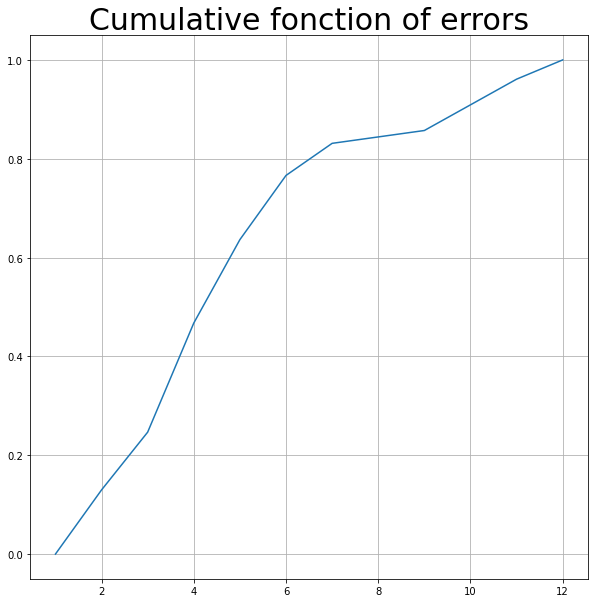

In [ ]:
date_pot_hurricanes_2=output.time[[i for i, x in enumerate((abs(np.diff((np.array(mean_without_cycle)**2+np.array(std_without_cycle)**2)**(1/2),axis=0))>0.37)) if x]]
true_hurricanes= []
false_hurricanes = []
cpt=0
for e in date_pot_hurricanes_2 :
  if e in date_known_hurricanes:
    cpt +=1 
    if (e-1) not in true_hurricanes and (e-2) not in true_hurricanes :
      true_hurricanes.append(e)
      #print(e-1)
  else :
    false_hurricanes .append(datetime.datetime.fromordinal(int(e)))


print("Nomber of points detecting a listed hurricane :",cpt)
precision= cpt/len(date_pot_hurricanes_2)
print("precision is ", precision*100)

full_true_hurricanes = {}
for e in true_hurricanes : 
  for index, row in known_hurricanes.iterrows():
    if int(row['start']) <= e and e <= int(row['end']):
      full_true_hurricanes[row['name']]=datetime.datetime.fromordinal(int(e))
      break
print(full_true_hurricanes)

[date.month for date in false_hurricanes]
[value.month for key, value in full_true_hurricanes.items()]
figure(figsize=(15,5))
plt.hist([date.month for date in false_hurricanes], bins=12, alpha =0.5, label = 'False Positive')
plt.hist([value.month for key, value in full_true_hurricanes.items()], bins=12, alpha =0.5, label = 'True Hurricane')
xlabel('Month', size=15)
plt.legend()
mois=[]
for i in range(1, 13):
  mois.append(len(false_hurricanes)-count_nonzero([date.month-i for date in false_hurricanes]))
plot(arange(1,13),mois)

somme=[]
for k in range(12):
  somme.append(sum(mois[0:k]))
plt.show()
figure(figsize=(10,10))
title('Cumulative fonction of errors', size=30)
plot(arange(1,13),somme/somme[-1])
grid()
full_true_hurricanes

We can see that more than 75% of the false positve are detected before the cyclonic period. Therefore this algorithm would be highly performant if used for only specific period and would not mistaken hurricanes

### Mix of both detection

number of point associated to listed hurricanes : 33
Precision :  0.673469387755102
[0, 0, 0, 1, 4, 4, 0, 0, 2, 4, 0, 1]


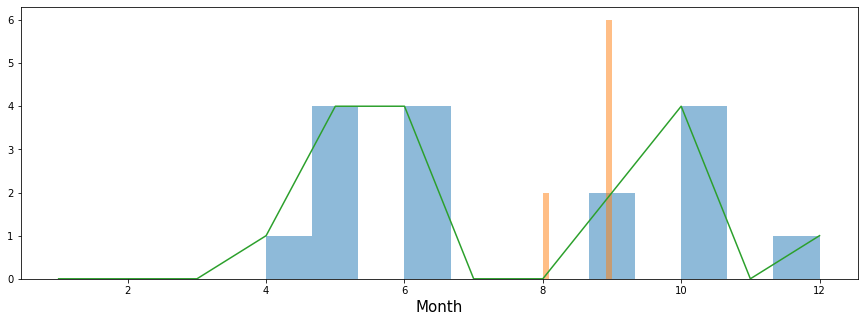

{'Georges': datetime.datetime(1998, 9, 27, 0, 0),
 'Gustav': datetime.datetime(2008, 9, 1, 0, 0),
 'Ike': datetime.datetime(2008, 9, 11, 0, 0),
 'Isaac': datetime.datetime(2012, 8, 28, 0, 0),
 'Isidore': datetime.datetime(2002, 9, 25, 0, 0),
 'Ivan': datetime.datetime(2004, 9, 15, 0, 0),
 'Katrina': datetime.datetime(2005, 8, 28, 0, 0),
 'Rita': datetime.datetime(2005, 9, 21, 0, 0)}

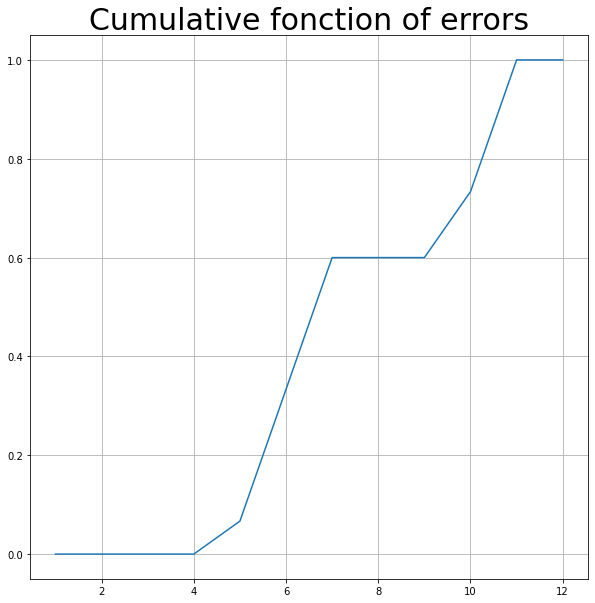

In [ ]:
#lst1=extract.values
lst1=extract
lst2=date_pot_hurricanes_2.values
#for i in range(len(lst1)):
  #lst1[i] = int(lst1[i])
#for i in range(len(lst2)):
  #lst2[i] = int(lst2[i])

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if int(value) in lst2]
    lst3 += [value for value in lst1 if int(value-1) in lst2]
    lst3 += [value for value in lst1 if int(value+1) in lst2]
    lst3 += [value for value in lst1 if int(value-2) in lst2]
    lst3 += [value for value in lst1 if int(value+2) in lst2]
    return lst3

extr = intersection(lst1,lst2)


date_pot_hurricanes = []
false_hurricanes = []
cpt=0
for e in extr :
  if e in date_known_hurricanes:
    cpt +=1 
    if (e-1) not in date_pot_hurricanes and (e-2) not in date_pot_hurricanes :
      date_pot_hurricanes.append(e)
  else :
    false_hurricanes.append(datetime.datetime.fromordinal(int(e)))
      #print(e-1)

print("number of point associated to listed hurricanes :",cpt)
print('Precision : ', cpt/len(extr))

pot_hurricanes = {}
for e in date_pot_hurricanes : 
  for index, row in known_hurricanes.iterrows():
    if int(row['start']) <= e and e <= int(row['end']):
      pot_hurricanes[row['name']]=datetime.datetime.fromordinal(int(e))
      break


mois = [elem.month for elem in false_hurricanes]
figure(figsize=(15,5))
plt.hist([date.month for date in false_hurricanes], bins=12, alpha =0.5, label='False positive')
plt.hist([value.month for key, value in pot_hurricanes.items()], bins=12, alpha =0.5, label = "True Hurricanes")
xlabel('Month', size=15)
mois=[]
for i in range(1, 13):
  mois.append(len(false_hurricanes)-count_nonzero([date.month-i for date in false_hurricanes]))
plot(arange(1,13),mois)
print(mois)
somme=[]
for k in range(12):
  somme.append(sum(mois[0:k]))
plt.show()
figure(figsize=(10,10))
title('Cumulative fonction of errors', size=30)

plot(arange(1,13),somme/somme[-1])
grid()
pot_hurricanes

When mixing both methods, we can reach 67% of precision for the whole database. This method takes the intersection of the objects detected by both of the methods and therefore withdraws uncommun false positive. However, some hurricanes are lost, if they are detected by only one of our two criteria.

## Part 3) Tracking of Hurricanes

This part will focus on Katrina Period and shows an animation of the trail of the cold water that occurs after an hurricane.

In [ ]:
%%bigquery --project alert-ground-261008 katrina
SELECT time, lon, lat, AVG(sst) as avg_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>260 AND lon<280 AND lat>20 AND lat<35 and year=2005 and dayofyear>225 and dayofyear<285
GROUP BY lon, lat, time
ORDER BY time

In [ ]:
filenames = []
for i in katrina.time.unique():
    dataset = katrina.where(katrina.time==i).dropna()
    lon=dataset.lon
    lat = dataset.lat
    im = dataset.avg_sst
    size_points=100
    var_name='Sea Surface Temperature'
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0, vmin=25, vmax=33)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=30)
    date=datetime.datetime.fromordinal(int(i))
    date_name = str(date.day)+"/"+str(date.month)+"/"+str(date.year)
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    plt.title(date_name, size=30)
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
    
images = list()
for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)
imageio.mimsave("katrina.gif", images)
files.download('katrina.gif')

# Remove files
for filename in set(filenames):
    os.remove(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>